In [3]:
!pip install tensorflow

In [5]:
!pip install opencv-python matplotlib

In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [1]:
# http://vis-www.cs.umass.edu/lfw/

In [13]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [8]:
# Move LFW Images to the following repository data/negative

for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [5]:
import uuid

In [6]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\5e4b247a-d793-11ec-b5e5-aced5c6c25d6.jpg'

In [95]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    frame = frame[120:120+250,200:200+250, :]
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    if cv2.waitKey(1) & 0XFF == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
    
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

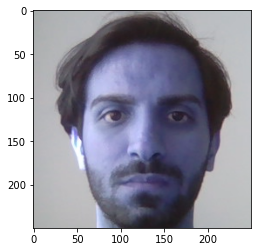

In [208]:
plt.imshow(frame)

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(50)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(50)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(50)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
print(dir_test.next())

b'data\\anchor\\075ecac4-d771-11ec-854c-aced5c6c25d6.jpg'


In [10]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [11]:
img = preprocess('data\\anchor\\8b68ed49-d787-11ec-b5a0-aced5c6c25d6.jpg')
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.67058825, 0.6666667 , 0.6509804 ],
        [0.67058825, 0.6666667 , 0.64705884],
        [0.6745098 , 0.67058825, 0.6509804 ],
        ...,
        [0.76862746, 0.75392157, 0.74019605],
        [0.76862746, 0.75686276, 0.7372549 ],
        [0.76862746, 0.75686276, 0.7372549 ]],

       [[0.67058825, 0.6666667 , 0.6509804 ],
        [0.6723039 , 0.66838235, 0.6526961 ],
        [0.6752451 , 0.67132354, 0.65343136],
        ...,
        [0.76862746, 0.75686276, 0.7352941 ],
        [0.76862746, 0.75686276, 0.7352941 ],
        [0.76862746, 0.75686276, 0.7352941 ]],

       [[0.6735294 , 0.6696078 , 0.65392154],
        [0.6745098 , 0.67058825, 0.654902  ],
        [0.6784314 , 0.6745098 , 0.65882355],
        ...,
        [0.76862746, 0.75686276, 0.7294118 ],
        [0.76862746, 0.75686276, 0.7294118 ],
        [0.76862746, 0.75686276, 0.7294118 ]],

       ...,

       [[0.67745095, 0.6852941 , 0.66568625],
        [0.68

In [12]:
img.numpy().max() 

1.0

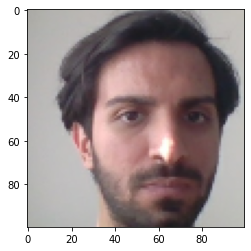

In [13]:
plt.imshow(img)

In [ ]:
dataset.map(preprocess)

In [14]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [16]:
samples = data.as_numpy_iterator()

In [17]:
exampple = samples.next()

In [18]:
exampple

(b'data\\anchor\\9eed8259-d787-11ec-a6bd-aced5c6c25d6.jpg',
 b'data\\positive\\bf637204-d787-11ec-bb74-aced5c6c25d6.jpg',
 1.0)

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*exampple)

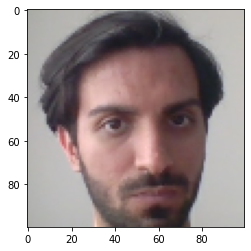

In [21]:
plt.imshow(res[0])

In [22]:
res[2]

1.0

In [23]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [24]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [25]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# MODEL

## Build Embedding Layer

In [26]:
inp = Input(shape=(100,100,3), name='input_image')

In [27]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [28]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [29]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [30]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [31]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [32]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [33]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [34]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [35]:
embedding = make_embedding()

In [36]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 46, 46, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

## Build Distance Layer

In [37]:
# Siamese L1 mesafe sınıfı
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [38]:
l1 = L1Dist()

In [39]:
l1

## Siamese(Siyam) Model

In [40]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [41]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [42]:
siamese_layer = L1Dist()

In [43]:
distances = siamese_layer(inp_embedding, val_embedding)

In [44]:
classifier = Dense(1, activation='sigmoid')(distances)

In [45]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [46]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [47]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [48]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [49]:
siamese_model = make_siamese_model()

In [50]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## TRAINING

In [51]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [52]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [53]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [54]:
test_batch = train_data.as_numpy_iterator()

In [55]:
test_batch.next()

(array([[[[0.5803922 , 0.5686275 , 0.54901963],
          [0.5882353 , 0.5764706 , 0.5568628 ],
          [0.595098  , 0.5833333 , 0.5637255 ],
          ...,
          [0.7710784 , 0.7463235 , 0.7362745 ],
          [0.76887256, 0.74852943, 0.7370098 ],
          [0.76936275, 0.7497549 , 0.7379902 ]],
 
         [[0.58137256, 0.57254905, 0.5421569 ],
          [0.5862745 , 0.577451  , 0.5470588 ],
          [0.59068626, 0.57965684, 0.5514706 ],
          ...,
          [0.764951  , 0.75147057, 0.7389706 ],
          [0.77156866, 0.7558824 , 0.7441176 ],
          [0.7703431 , 0.75465685, 0.74289215]],
 
         [[0.5732843 , 0.5732843 , 0.53995097],
          [0.5803922 , 0.5803922 , 0.5470588 ],
          [0.5879902 , 0.5857843 , 0.55465686],
          ...,
          [0.76666665, 0.75980395, 0.74509805],
          [0.7776961 , 0.7620098 , 0.7502451 ],
          [0.78333336, 0.7676471 , 0.7558824 ]],
 
         ...,
 
         [[0.64117646, 0.6490196 , 0.6372549 ],
          [0.64313

In [56]:
batch_1 = test_batch.next()

In [57]:
batch_1[2]

array([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

In [58]:
X = batch_1[:2]

In [59]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [60]:
y = batch_1[2]

In [61]:
y

array([0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

In [64]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export('keras.losses.BinaryCrossentropy')
class BinaryCrossentropy(LossFunctionWrapper):
  """Computes the cross-entropy loss between true labels and predicted labels.

  Use this cross-entropy loss for binary (0 or 1) classification applications.
  The loss function requires the following inputs:

  - `y_true` (true label): This is either 0 or 1.
  - `y_pred` (predicted value): This is the model's prediction, i.e, a single
    floating-point value which either represents a
    [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
    when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
    `from_logits=False`).

  **Recommended Usage:** (set `from_logits=True`)

  With `tf.keras` API:

  ```python
  model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_log

In [65]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [66]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [67]:
EPOCHS = 40

In [68]:
train(train_data, EPOCHS)


 Epoch 1/40
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
5/5 [==============================] - 108s 21s/step

 Epoch 2/40
5/5 [==============================] - 109s 21s/step

 Epoch 3/40
5/5 [==============================] - 112s 22s/step

 Epoch 4/40
5/5 [==============================] - 111s 21s/step

 Epoch 5/40
5/5 [==============================] - 109s 21s/step

 Epoch 6/40
5/5 [==============================] - 109s 21s/step

 Epoch 7/40
5/5 [==============================] - 110s 21s/step

 Epoch 8/40
5/5 [==============================] - 110s 21s/step

 Epoch 9/40
5/5 [==============================] - 109s 21s/step

 Epoch 10/40
5/5 [==============================] - 110s 21s/step

 Epoch 11/40
5/5 [==============================] - 114s 22s/step

 Epoch 12/40
5/5 [==============================] - 109s 21s/step

 Epoch 13/40
5/5 [==============================] 

In [70]:
from tensorflow.keras.metrics import Precision, Recall

In [71]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [72]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[7.4041077e-06],
       [2.3531914e-04],
       [9.9955761e-01],
       [2.1119293e-05],
       [9.9999797e-01],
       [5.3947697e-05],
       [9.9854696e-01],
       [3.4561577e-05],
       [9.8042801e-07],
       [3.1972373e-05],
       [9.9948323e-01],
       [9.9987841e-01],
       [9.9998868e-01],
       [9.9978697e-01],
       [9.9994373e-01],
       [7.6669455e-04]], dtype=float32)

In [73]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]

In [74]:
y_true

array([0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.],
      dtype=float32)

In [75]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [76]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

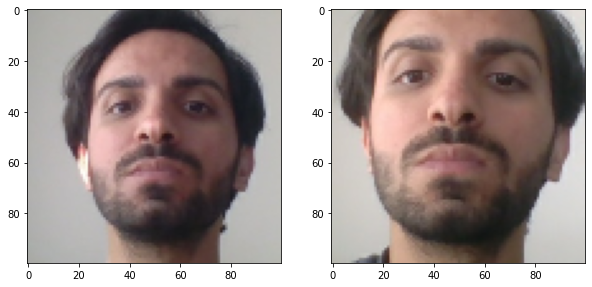

In [84]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[6])

# Renders cleanly
plt.show()

In [85]:
# Save model
siamese_model.save('bestsiamesemodel.h5')

In [86]:
L1Dist

__main__.L1Dist

In [87]:
# Reload model 
model = tf.keras.models.load_model('bestsiamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [88]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

array([[7.4041077e-06],
       [2.3531914e-04],
       [9.9955761e-01],
       [2.1119293e-05],
       [9.9999797e-01],
       [5.3947697e-05],
       [9.9854696e-01],
       [3.4561577e-05],
       [9.8042801e-07],
       [3.1972373e-05],
       [9.9948323e-01],
       [9.9987841e-01],
       [9.9998868e-01],
       [9.9978697e-01],
       [9.9994373e-01],
       [7.6669455e-04]], dtype=float32)

In [89]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

## TEST

In [96]:
os.listdir(os.path.join('application_data', 'verification_images'))

['7d7347d9-d7ae-11ec-97d1-aced5c6c25d6.jpg',
 '7e825f7d-d7ae-11ec-8356-aced5c6c25d6.jpg',
 '7e8949cd-d7ae-11ec-b490-aced5c6c25d6.jpg',
 '7eb63674-d7ae-11ec-8ac8-aced5c6c25d6.jpg',
 '7f11a800-d7ae-11ec-b692-aced5c6c25d6.jpg',
 '7f1da5d5-d7ae-11ec-a84f-aced5c6c25d6.jpg',
 '7f3333c0-d7ae-11ec-83dc-aced5c6c25d6.jpg',
 '7f3a68b7-d7ae-11ec-9061-aced5c6c25d6.jpg',
 '7f9927c7-d7ae-11ec-aa4c-aced5c6c25d6.jpg',
 '7fa05ac8-d7ae-11ec-a849-aced5c6c25d6.jpg',
 '7fe9fdb7-d7ae-11ec-95da-aced5c6c25d6.jpg',
 '803ac825-d7ae-11ec-b5f3-aced5c6c25d6.jpg']

In [97]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [98]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\7d7347d9-d7ae-11ec-97d1-aced5c6c25d6.jpg
application_data\verification_images\7e825f7d-d7ae-11ec-8356-aced5c6c25d6.jpg
application_data\verification_images\7e8949cd-d7ae-11ec-b490-aced5c6c25d6.jpg
application_data\verification_images\7eb63674-d7ae-11ec-8ac8-aced5c6c25d6.jpg
application_data\verification_images\7f11a800-d7ae-11ec-b692-aced5c6c25d6.jpg
application_data\verification_images\7f1da5d5-d7ae-11ec-a84f-aced5c6c25d6.jpg
application_data\verification_images\7f3333c0-d7ae-11ec-83dc-aced5c6c25d6.jpg
application_data\verification_images\7f3a68b7-d7ae-11ec-9061-aced5c6c25d6.jpg
application_data\verification_images\7f9927c7-d7ae-11ec-aa4c-aced5c6c25d6.jpg
application_data\verification_images\7fa05ac8-d7ae-11ec-a849-aced5c6c25d6.jpg
application_data\verification_images\7fe9fdb7-d7ae-11ec-95da-aced5c6c25d6.jpg
application_data\verification_images\803ac825-d7ae-11ec-b5f3-aced5c6c25d6.jpg


In [108]:
def verify(model, detection_threshold, verification_threshold):
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

# OpenCV Verification

In [101]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('v'):
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
True
False
True
True
True
False


In [95]:
np.sum(np.squeeze(results) > 0.9)

21